<a href="https://colab.research.google.com/github/mu132/mu132/blob/main/3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

رنگ 10 کندل بعدی

برنامه 50 عدد دیتا میگیرد تا بسته شدن کندل 51 رو پیش بینی کند
حال می خواهیم 10 کندل بعدی را پیش بینی کند


 یعنی وقتی بسته شدن کندل 51 رو پیش بینی کرد باید آنرا به عنوان باز شدن کندل 52 ام قرار داد و حال دوباره برنامه را 9 بار تکرار کرد

مشکل 1: وجود افست

مشکل 2: باقی اطلاعات کندل 51 چطور ساخته شود

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import sklearn 
## read csv
df = pd.read_excel('drive/My Drive/eurusd10.xlsx') 
df.head(5)
data = df
df = pd.DataFrame(data)
data_np = df.to_numpy()

Mounted at /content/drive


In [3]:
df.shape

(100000, 5)

In [4]:
pip install pandas-ta

     |████████████████████████████████| 115 kB 11.4 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=d8c47cb69e1c8da501c7c2dc59895a5a0d2d68d6606f87b469685697308d9c81
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [5]:
import pandas_ta as ta

# macd اضافه کردن 

In [6]:
macd = df.ta.macd()
df =np.concatenate((df, macd), axis=1)

In [7]:
df.shape

(100000, 8)

# خروجی

In [8]:
#pd.DataFrame(df).to_excel('drive/My Drive/df+macd.xlsx', index=False)

In [9]:
x_train = df[-20000:-2000]
x_val = df[-2000+1:-1000]
x_test = df[-1000+1:]
y_test_rr = x_test[50:,3]
y_test = list(range(0,1000))
z_test = list(range(0,1000))

In [10]:
x_train.shape

(18000, 8)

In [11]:
x_train.shape[0]

18000

برای داده‌های ما رنج قیمت‌ها و حجم معاملات بسیار متفاوت هستند. بنابراین باید داده‌ها استاندارد شوند. ما استانداردسازی را با استفاده از کمترین و بیشترین مقدار داده‌ها انجام خواهیم داد.

In [12]:
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler().fit(x_train)
x_train_n = minmax_scale.transform(x_train)
x_val_n = minmax_scale.transform(x_val)
x_test_n = minmax_scale.transform(x_test)

می‌خواهیم قیمت سهام در هنگام باز شدن بازار را تخمین بزنیم. ما در این پروژه داده‌های مربوط به 50 روز را به شبکه می‌دهیم و می‌خواهیم مقدار قیمت باز شدن سهام را در روز بعد تخمین بزند. به همین دلیل ابتدا داده‌ها را 50 تا 50 تا جدا می‌کنیم. همینجا مقدار قیمت باز شدن را در روز 51اُم را نیز به عنوان برچسب جدا می‌کنیم.

In [13]:
def slicing_50(x, history_points):
    sliced_data = np.array([x[i  : i + history_points] for i in range(len(x) - history_points)])
    labels = np.array([x[:,3][i + history_points] for i in range(len(x) - history_points)])
    return sliced_data, labels

 با استفاده از تابعی که نوشتیم، داده‌های آموزش، اعتبارسنجی و تست را 50تا 50تا جدا کرده و برچسب‌هایشان را نیز جدا می‌کنیم.

In [14]:
history_points = 50
x_train_n, y_train = slicing_50(x_train_n, history_points)
x_val_n, y_val = slicing_50(x_val_n, history_points)
x_test_n, y_test = slicing_50(x_test_n, history_points)

In [15]:
x_train_n.shape

(17950, 50, 8)

د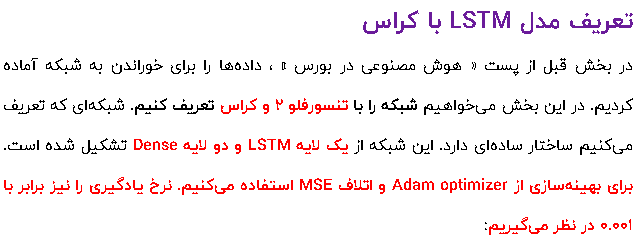

In [16]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)

lstm_input = Input(shape=(history_points, df.shape[1]), name='lstm_input')#5
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = tf.optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:


from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('./stocks_price.h5', save_best_only=True, monitor='val_loss', mode='min')


In [18]:
x_train_n.shape


(17950, 50, 8)

In [19]:
y_train.shape

(17950,)

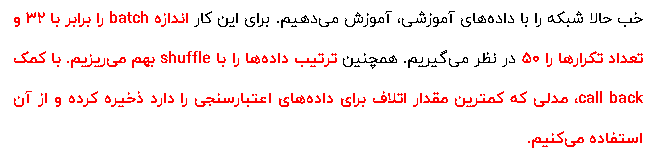

In [20]:
history = model.fit(x=x_train_n, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_data=(x_val_n, y_val), callbacks=[mcp_save])

Epoch 1/50
561/561 [==============================] - 17s 19ms/step - loss: 0.0039 - val_loss: 8.8370e-04
Epoch 2/50
561/561 [==============================] - 10s 17ms/step - loss: 8.7270e-04 - val_loss: 4.0910e-04
Epoch 3/50
561/561 [==============================] - 9s 16ms/step - loss: 7.0273e-04 - val_loss: 8.7477e-05
Epoch 4/50
561/561 [==============================] - 7s 13ms/step - loss: 6.7524e-04 - val_loss: 7.5656e-05
Epoch 5/50
561/561 [==============================] - 7s 13ms/step - loss: 6.3886e-04 - val_loss: 4.1488e-04
Epoch 6/50
561/561 [==============================] - 7s 13ms/step - loss: 6.2455e-04 - val_loss: 1.3212e-04
Epoch 7/50
561/561 [==============================] - 7s 13ms/step - loss: 6.0130e-04 - val_loss: 2.4148e-04
Epoch 8/50
561/561 [==============================] - 7s 13ms/step - loss: 6.0899e-04 - val_loss: 1.8013e-04
Epoch 9/50
561/561 [==============================] - 7s 13ms/step - loss: 5.9999e-04 - val_loss: 5.2177e-05
Epoch 10/50
561/561 [

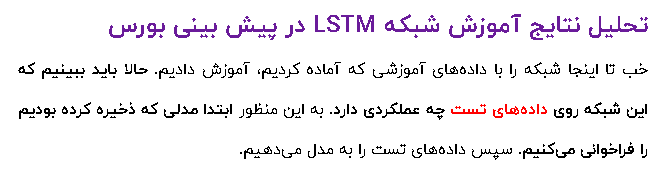

In [21]:
model.load_weights('./stocks_price.h5')
evaluation = model.evaluate(x_test_n, y_test)
print(evaluation)

30/30 [==============================] - 0s 6ms/step - loss: 7.0987e-05
7.098673086147755e-05


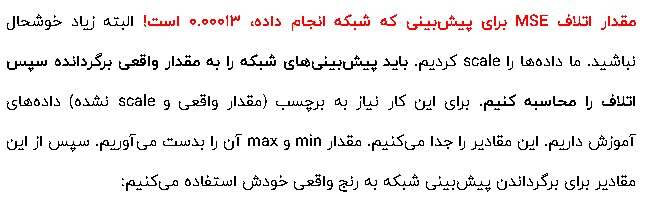

In [22]:
y_train_real = np.array([x_train[:,3][i + history_points] for i in range(len(x_train) - history_points)])
scale_back = preprocessing.MinMaxScaler().fit(np.expand_dims(y_train_real, -1))

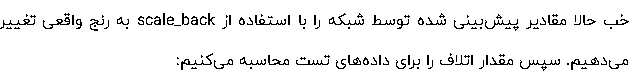

In [23]:
y_test_predicted = model.predict(x_test_n)
x_test_n.shape


(949, 50, 8)

In [24]:
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
y_test_real = np.array([x_test[:,3][i + history_points] for i in range(len(x_test) - history_points)])
real_mse = np.square(np.mean(y_test_real - y_test_predicted))
print(real_mse)

4.4193390005472815e-08


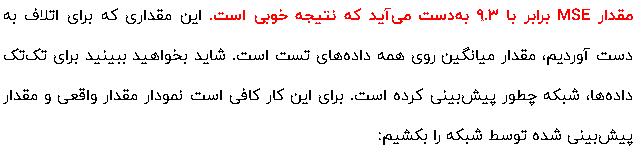

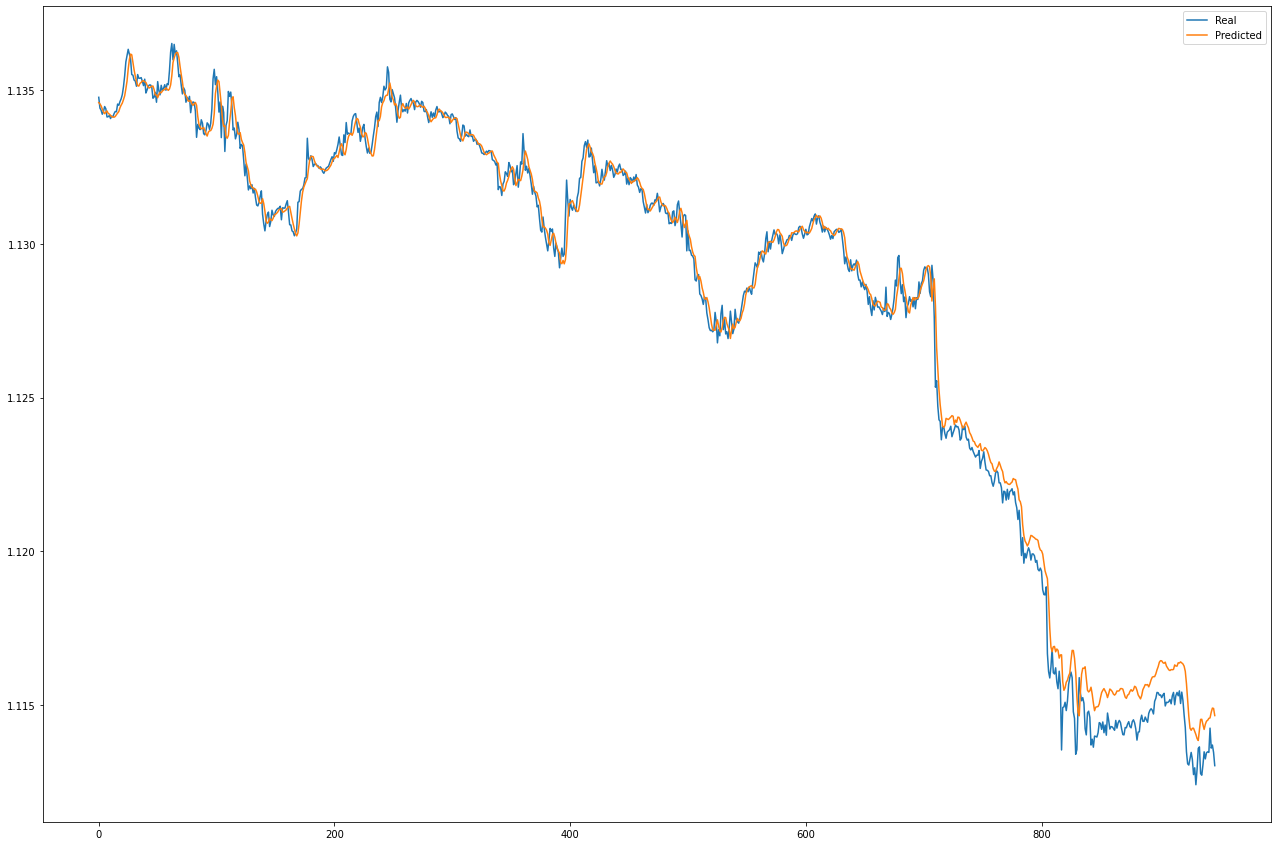

In [25]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')



plt.legend(['Real', 'Predicted'])

plt.show()

In [26]:
y_test_predicted.shape

(949, 1)

In [27]:
y_test_real.shape

(949,)

In [28]:
y_test_real = y_test_real.reshape(949,1)
y_test_real.shape

(949, 1)

In [29]:
y_test_real[0]

array([1.13476])

In [30]:
for i in range(0,948):
    if x_test[i,3] >= y_test_real[i,0]:
        y_test[i] = 1
    else:
        y_test[i] = 0 



In [31]:
#for i in range(0,948):
#    if x_test[i,3] >= x_test[i,0]:
 #       y_test[i] = 1
 #   else:
 #       y_test[i] = 0 


In [32]:
y_test.shape

(949,)

In [33]:
for i in range(0,948):
    if x_test[i,0] >= y_test_predicted[i,0]:
        z_test[i] = 1
    else:
        z_test[i] = 0 


In [34]:
import sklearn 
from sklearn.metrics import accuracy_score
accuracy_score(y_test[0:948], z_test[0:948])

0.9335443037974683

In [35]:
x_test = df[-51:]
x_test_n = minmax_scale.transform(x_test)
x_test_n, y_test = slicing_50(x_test_n, history_points)
y_test_predicted = model.predict(x_test_n)
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
y_test_real = np.array([x_test[:,3][i + history_points] for i in range(len(x_test) - history_points)])
y_test_predicted 

array([[1.1144118]], dtype=float32)

In [36]:
x_test = df[-52:]
x_test[51] =x_test[50] 
x_test[51,0] = y_test_predicted 
x_test[51]

array([ 1.11441183e+00,  1.11348000e+00,  1.11278000e+00,  1.11304000e+00,
        9.69000000e+02, -1.53060535e-04,  6.96880822e-05, -2.22748617e-04])

In [37]:
def predict(x_in,y_in):
    x_test = x_in
    x_test[51] =x_test[50] 
    x_test[51,0] = y_in
    x_test_n = minmax_scale.transform(x_test)
    x_test_n, y_test = slicing_50(x_test_n, history_points)
    y_test_predicted = model.predict(x_test_n)
    y_test_predicted = scale_back.inverse_transform(y_test_predicted)
    y_test_real = np.array([x_test[:,3][i + history_points] for i in range(len(x_test) - history_points)])
    return y_test_predicted 

In [38]:
y = print(predict(df[-52:],y_test_predicted)[1])
print(predict(df[-52:],y))

[1.1144118]
[[1.1146677]
 [1.1144118]]


In [39]:
y = print(predict(x_test,1)[1])
print(predict(x_test,1))

[1.1144118]
[[1.1146677]
 [1.1144118]]


In [40]:
print(predict(x_test,y_test_predicted))

[[1.1146677]
 [1.1144118]]


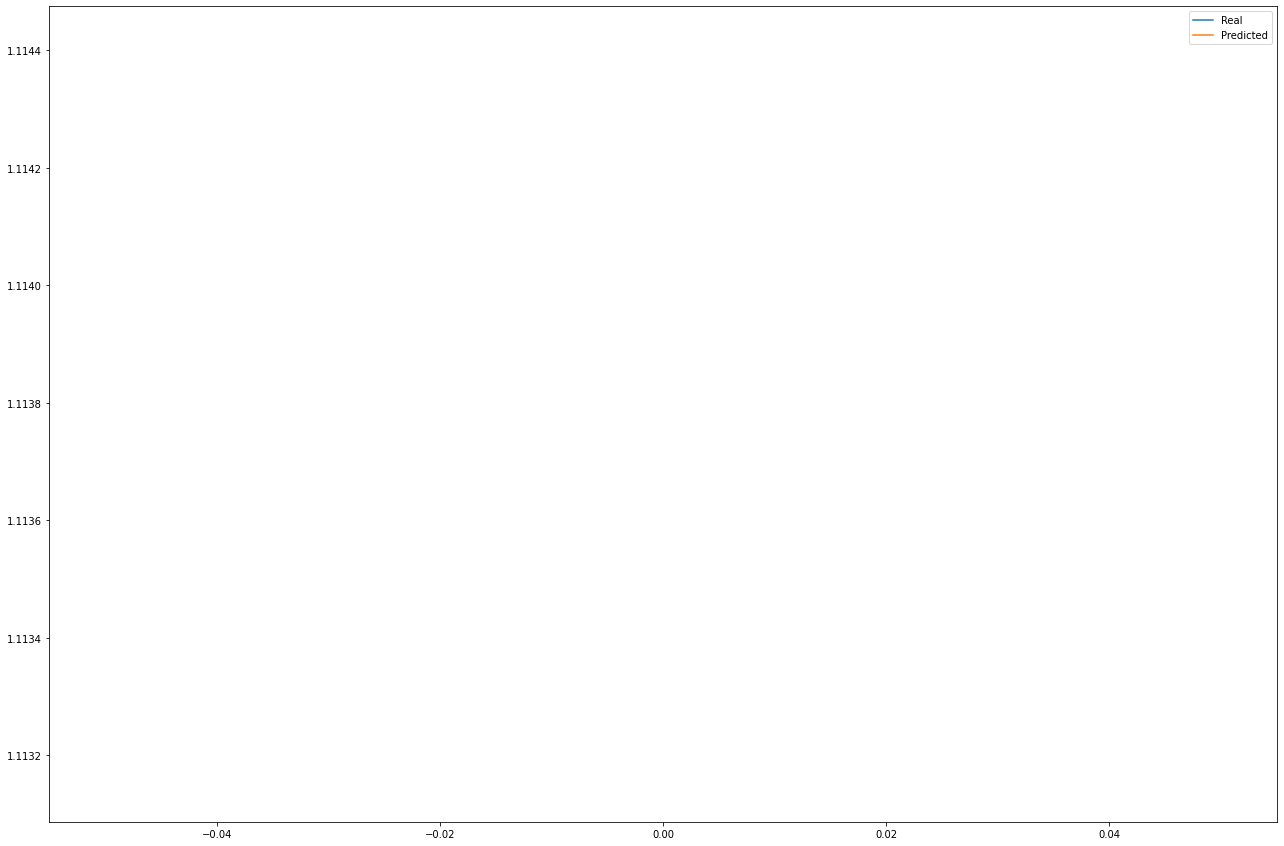

In [41]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[0:y_test_real.shape[0]], label='real')#[start:end]
pred = plt.plot(y_test_predicted[0:y_test_predicted.shape[0]], label='predicted') #[start:end]

plt.legend(['Real', 'Predicted'])

plt.show()